In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
import random as rd
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'Number of GPU\'s: {len(gpus)}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 
#Limits the memory growth of the GPU and makes sure the program just uses the requested GPU power.

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPU's: 1


In [2]:
from tensorflow.keras.datasets import fashion_mnist
import warnings
warnings.filterwarnings("ignore")

In [3]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
              
len(labels)

10

In [5]:
train_data, test_data = train_data/255, test_data/255
train_data.min(), train_data.max()

(0.0, 1.0)

In [6]:
def show_img():
    plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3, i+1)
        rand_ind = rd.choice(range(len(train_data)))
        plt.imshow(train_data[rand_ind], cmap = plt.cm.RdYlBu)
        plt.title(labels[train_labels[rand_ind]])
        plt.axis(False)
        
    

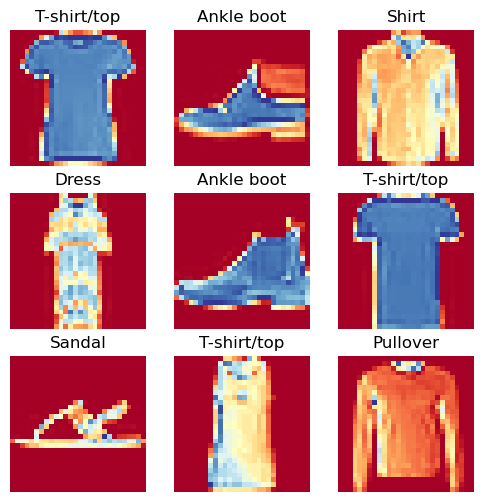

In [7]:
show_img()

In [8]:
# train, test = tf.one_hot(train_labels, depth = len(labels)), tf.one_hot(test_labels, depth = len(labels))
# train[0], test[0]

In [9]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(10, activation = 'softmax')
    ])

model_1.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = 'Adam',
    metrics = ['accuracy']
    )

model_1_history = model_1.fit(train_data, train_labels, epochs = 10, validation_data =(test_data, test_labels))

Metal device set to: Apple M1


2023-03-08 18:17:31.611706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 18:17:31.611828: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-03-08 18:17:31.886949: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-08 18:17:32.001664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 0.4919 - accuracy: 0.8259

2023-03-08 18:17:41.288303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.4919 - accuracy: 0.8259 - val_loss: 0.4087 - val_accuracy: 0.8504
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3641 - accuracy: 0.8654 - val_loss: 0.4162 - val_accuracy: 0.8530
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3303 - accuracy: 0.8783 - val_loss: 0.3803 - val_accuracy: 0.8598
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3096 - accuracy: 0.8855 - val_loss: 0.3842 - val_accuracy: 0.8577
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2932 - accuracy: 0.8909 - val_loss: 0.3542 - val_accuracy: 0.8726
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2782 - accuracy: 0.8961 - val_loss: 0.3506 - val_accuracy: 0.8710
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2680 - accuracy: 0.9000 - val_loss: 0.3551 - val_accuracy: 0.8

<Axes: title={'center': 'Model: Normalised Data'}>

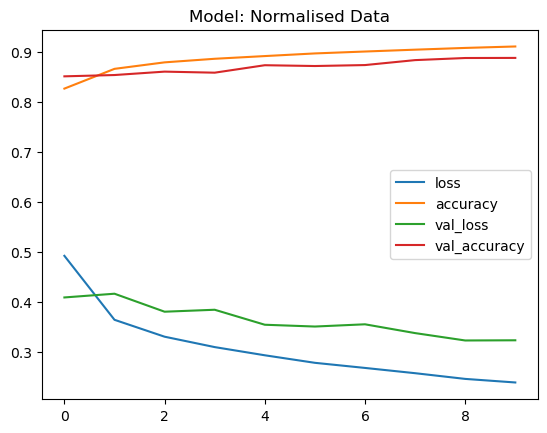

In [10]:
pd.DataFrame(model_1_history.history).plot(title= "Model: Normalised Data")

In [11]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model_2.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics =['accuracy']
)
lr_scheduler_2 = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

model_2_history = model_2.fit(train_data,
                               train_labels,
                               epochs=40, 
                               validation_data=(test_data, test_labels),
                               callbacks=[lr_scheduler_2])

Epoch 1/40


2023-03-08 19:19:24.678895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1874/1875 [============================>.] - ETA: 0s - loss: 1.0350 - accuracy: 0.6474

2023-03-08 19:19:38.043029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 15s 8ms/step - loss: 1.0348 - accuracy: 0.6474 - val_loss: 0.6937 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 2/40
1875/1875 [==============================] - 14s 7ms/step - loss: 0.6366 - accuracy: 0.7759 - val_loss: 0.6400 - val_accuracy: 0.7808 - lr: 0.0011
Epoch 3/40
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5934 - accuracy: 0.7912 - val_loss: 0.6278 - val_accuracy: 0.7770 - lr: 0.0013
Epoch 4/40
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5749 - accuracy: 0.7969 - val_loss: 0.6122 - val_accuracy: 0.7871 - lr: 0.0014
Epoch 5/40
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5655 - accuracy: 0.7987 - val_loss: 0.6061 - val_accuracy: 0.7913 - lr: 0.0016
Epoch 6/40
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5569 - accuracy: 0.8022 - val_loss: 0.5917 - val_accuracy: 0.7940 - lr: 0.0018
Epoch 7/40
1875/1875 [==============================] - 13s 7ms

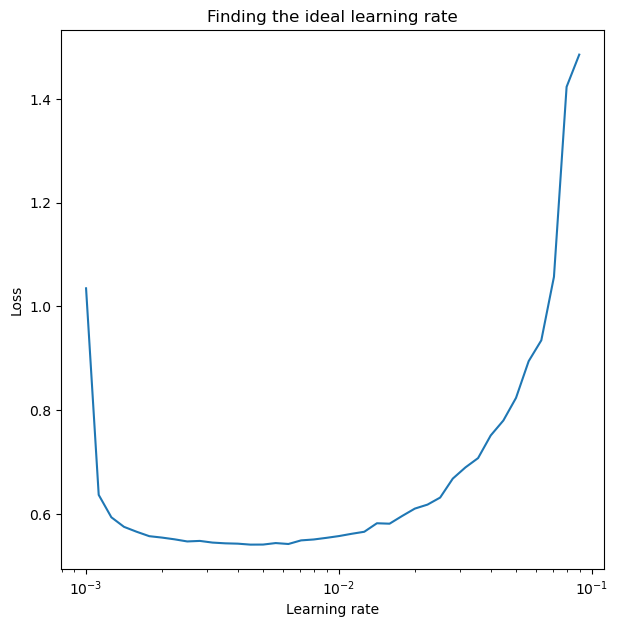

In [13]:
plt.figure(figsize=(7,7))
lrs = 1e-3 * (10**(np.arange(40)/20))
plt.semilogx(lrs, model_2_history.history["loss"]) # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

In [15]:
lrs[model_2_history.history['loss'].index(min(model_2_history.history['loss']))], model_2_history.history['loss'].index(min(model_2_history.history['loss']))

(0.004466835921509632, 13)

In [17]:
lrs[12]

0.0039810717055349725

In [ ]:
tf.random.set_seed(42)
model_3 =tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_3.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr = 0.003),
    metrics = ['accuracy']
)

model_3_history = model_3.fit(train_data,
                            train_labels,
                            epochs=10,
                            validation_data=(test_data, test_labels)
)

Epoch 1/10
  22/1875 [..............................] - ETA: 9s - loss: 2.2865 - accuracy: 0.1662

2023-03-08 19:31:30.072519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1868/1875 [============================>.] - ETA: 0s - loss: 1.5785 - accuracy: 0.3095

2023-03-08 19:31:39.176471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 1.5778 - accuracy: 0.3097 - val_loss: 1.4557 - val_accuracy: 0.3699
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.4194 - accuracy: 0.3787 - val_loss: 1.3403 - val_accuracy: 0.4180
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.2837 - accuracy: 0.4399 - val_loss: 1.2650 - val_accuracy: 0.4493
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.0499 - accuracy: 0.5490 - val_loss: 0.8911 - val_accuracy: 0.6243
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8562 - accuracy: 0.6284 - val_loss: 0.8680 - val_accuracy: 0.6348
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8397 - accuracy: 0.6356 - val_loss: 0.8750 - val_accuracy: 0.6273
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8327 - accuracy: 0.6388 - val_loss: 0.8598 - val_accuracy: 0.6